# Sech - Lest Squares

In [1]:
from math import exp, log, sqrt
from matplotlib import pyplot as plot
from scipy.linalg import lstsq
from scipy.optimize import fsolve
from scipy.stats import linregress
from sympy import Symbol, cosh, integrate, lambdify, oo, pi

import DistExampB as db

from Map import LogRatio
from LocUtil import Grid1, MinMax, IndexOf, Sub, UnZip

## Set Up

#### constants

In [2]:
nPlot = 501

#### problem

In [3]:
dist = db.ExampB()

#### maping

In [4]:
xSym = Symbol('x')
zSym = Symbol('z')
map_ = LogRatio(xSym, zSym, xRange=(0, 2))
map_.forSym

log(x/(2 - x))

In [5]:
X2Z = map_.Forward
Z2X = map_.Inverse

#### bases

In [6]:
hSym = Symbol('h', positive=True)
zkSym = Symbol('zk', real=True)

In [7]:
baseZ = 1/pi * 1 / cosh((zSym - zkSym) / hSym)
baseZ

1/(pi*cosh((z - zk)/h))

In [8]:
integrate(baseZ, (zSym,-oo,oo))

Integral(1/cosh(z/h - zk/h), (z, -oo, oo))/pi

In [9]:
BaseZ = lambdify((zSym,zkSym,hSym), baseZ)

Text(0.5, 0, 'h')

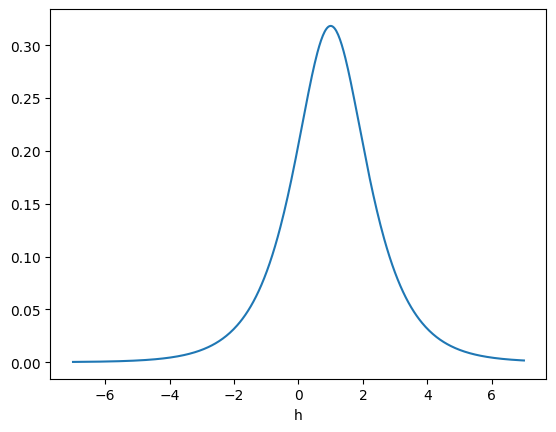

In [10]:
zGrid = Grid1(-7,7, nPlot)
baseGrid = tuple(BaseZ(z,1,1) for z in zGrid)

plot.plot(zGrid,baseGrid)

plot.xlabel('h')

## Fit to PDF

In [11]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [12]:
truncStep = 0.01
domainWidth = 2

In [13]:
zMin = fsolve(lambda z: PdfZ(z) - domainWidth * truncStep, -3)[0]
zMax = fsolve(lambda z: PdfZ(z) - domainWidth * truncStep, 6)[0]
zMin,zMax

(-2.852576143395742, 5.696832018615558)

(0.001, 2)

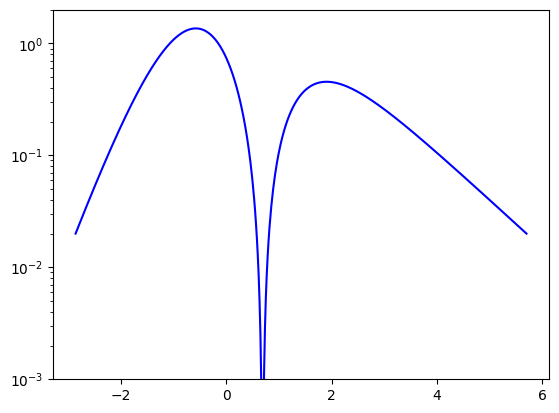

In [14]:
fig,ax = plot.subplots()

zGrid = Grid1(zMin,zMax, nPlot)
pdf = tuple(PdfZ(z) for z in zGrid)

plot.semilogy(zGrid,pdf, c='blue')

ax.set_ylim(1e-3,2)

In [15]:
def Fit(zRange, nBase):
	assert(1 < nBase)
	zMin,zMax = zRange
	
	sechZ = Grid1(*zRange, nBase)
	h = (zMax - zMin) / (nBase - 1)
	
	mat = []
	for matchZ in sechZ:
		mat.append([BaseZ(matchZ,baseZ,h) for baseZ in sechZ])
	rhs = [PdfZ(z) for z in sechZ]
	
	fit = lstsq(mat, rhs)
	weight,res,rank,singVal = fit

	condNum = singVal[0] / singVal[nBase - 1]
	
	return ((sechZ,weight),  condNum)

In [34]:
nSech = 21

In [35]:
sechApprox,condNum = Fit((zMin,zMax), nSech)
condNum

33.102873877509715

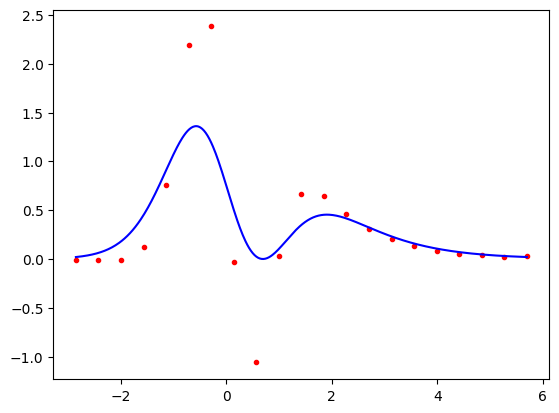

In [36]:
plot.plot(*sechApprox, '.', c='red')

plot.plot(zGrid, pdf, c='blue')

In [30]:
extZRange = tuple(z*s for (z,s) in zip((zMin,zMax), (2,2)))
extZRange

(-5.705152286791484, 11.393664037231115)

In [23]:
def Interp0(sechZ,sechV,h, z):
	result = sum(sv * BaseZ(z,sz,h) for (sz,sv) in zip(sechZ, sechV))

	return result

In [103]:
def Interp1(sechApprox, zGrid):
	sechZ,sechV = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = (sechZ[0], sechZ[nSech - 1])
	h = (zMax - zMin) / (nSech - 1)
	
	result = tuple(Interp0(sechZ,sechV,h, z) for z in zGrid)
	return result

(0.0001, 2)

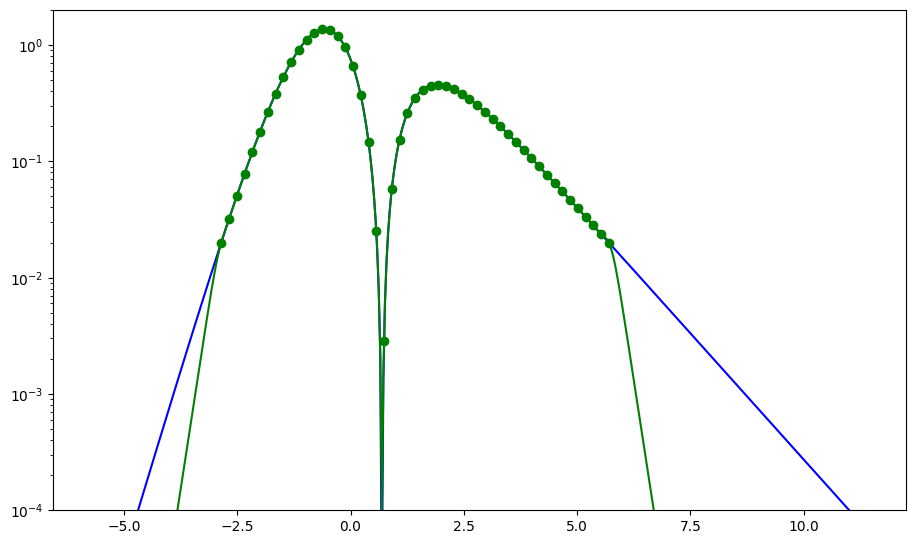

In [104]:
fig,ax = plot.subplots(figsize=(11, 6.5))

zGrid = Grid1(*extZRange, 501)
pdf = tuple(PdfZ(z) for z in zGrid)
plot.semilogy(zGrid,pdf, c='blue')

est = Interp1(sechApprox, zGrid)
plot.semilogy(zGrid,est, c='green')

sechZ,weight = sechApprox
sechV = tuple(PdfZ(z) for z in sechZ)
plot.semilogy(sechZ,sechV, 'o', c='green')
	
ax.set_ylim(1e-4,2)

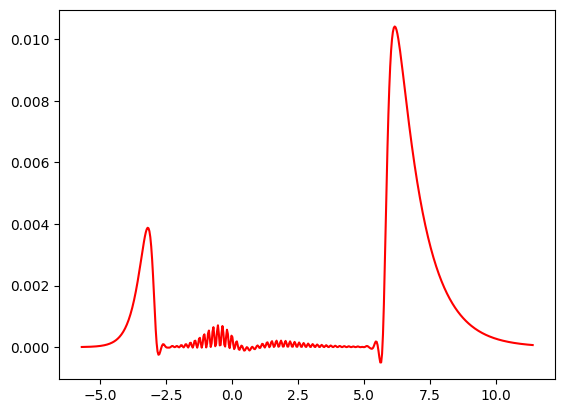

In [105]:
zGrid = Grid1(*extZRange, nPlot)
est = Interp1(sechApprox, zGrid)
pdf = tuple(dist.Pdf(map_.Inverse(z)) for z in zGrid)
diff = tuple(p - e for (p,e) in zip(pdf,est))

plot.plot(zGrid, diff, c='red')

# plot.plot(zGrid, pdf, c='blue')
# plot.plot(zGrid, est, c='green')

In [106]:
def ErrorZ(sechApprox, F):
	sechZ,weight = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = sechZ[0],sechZ[nSech - 1]
	h = (zMax - zMin) / (nSech - 1)
		
	Diff = lambda z: Interp0(sechZ,weight,h, z) - F(z)
	
	extZRange = tuple(z * s for (z,s) in zip((zMin,zMax), (2,2)))
	nSinc = 4 * nSech
	
	sincZ = Grid1(*extZRange, nSinc)
	diff = tuple(Diff(z) for z in sincZ)
	
	result = sqrt(h * sum(d*d for d in diff))
	return result

In [107]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [108]:
ErrorZ(sechApprox, PdfZ)

0.0146421067809185

In [109]:
def ErrN(F, nSech, zRange):
	sechEst,condNum = Fit(zRange,nSech)

	errEst = ErrorZ(sechEst, F)
	
	return (errEst, condNum)

In [110]:
nRange = tuple(range(3,70))

In [111]:
errN = tuple((n,ErrN(PdfZ,n,(zMin,zMax))) for n in nRange)

In [112]:
nL,info = UnZip(errN)
err,cond = UnZip(info)

In [122]:
fitRange = (5,21)

In [123]:
fitIndex = IndexOf(nL, lambda n: (fitRange[0] <= n) and (n <= fitRange[1]))
fitIndex

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [124]:
fitIndex = IndexOf(nL, lambda n: (5 <= n) and (n <= 21))
nSub = Sub(nL, fitIndex)
lnErr = tuple(log(e) for e in Sub(err, fitIndex))

slope,inter,_,_,_ = linregress(nSub,lnErr)
Fit = lambda n: exp(inter) * exp(slope * n)
InvFit = lambda err: (log(err) - inter) / slope

slope,exp(inter)

(-0.3709784545106791, 10.152659038428892)

Text(0, 0.5, 'RMS Error')

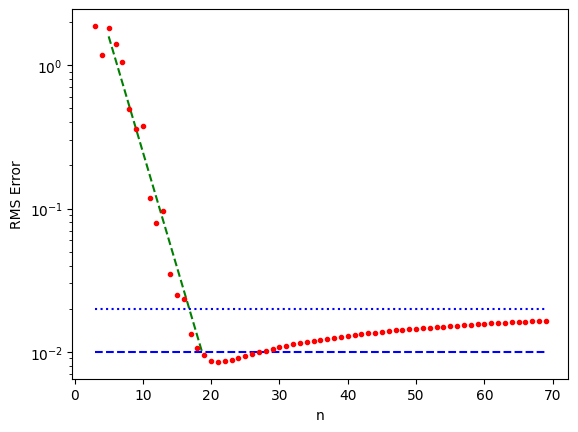

In [125]:
fig,ax = plot.subplots()

plot.semilogy(nL,err, '.', c='red')

nLim = MinMax(nRange)
plot.semilogy(nLim, tuple(2*truncStep for _ in range(2)), ':',c='blue', zorder=-1)
plot.semilogy(nLim, tuple(truncStep for _ in range(2)), '--',c='blue', zorder=-1)

nGrid = (fitRange[0], InvFit(truncStep))
fitGrid = tuple(map(Fit, nGrid))

plot.semilogy(nGrid,fitGrid, '--', c='green', zorder=-2)

plot.xlabel('n')
plot.ylabel('RMS Error')